### Description notebook : Distances covered by the drifters over a time period
#### Goals : Estimate the distance (in x and y) covered by drifters over a time period and how this could impact the other diags that have been previously computed (correlation, energy spectra).
#### References : No references for now

In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima
import matplotlib as mpl

import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.croco_drifter as cdr

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*2)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster


In [4]:
client

Client Scheduler: tcp://10.148.1.76:58644 Dashboard: http://10.148.1.76:8787/status,Cluster Workers: 56 Cores: 56 Memory: 240.24 GB


In [5]:
root_path = '/home/c11-data/Test_aponte/jetn/old/'
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

In [6]:
dr = cdr.drifter_dataframe(root_path+run, tdir_max=1)

In [7]:
# Definition parameters
t0 = 1550 #initial time
t1 = 1590 # final time
tmid = (t0+t1)/2 # mid period
flt_id = 225 # test drifter id

#### Functions to compute initial, final, maximal and minimal latitudes for each drifters over a period of time

In [51]:
def diags_dist(v1,v2,v3,v4,N):
#    fltI = flt.sel(time=slice(Ti,Tf))
    if v1 is None and v2 is None:
        return pd.Series(np.random.randn(N),index=['xmax','xmin','ymax','ymin','y0','y1','dx','dy','ds'])
    else : 
        dxint = np.abs(v3).mean()#np.diff(np.unwrap(v1)).sum()
        dyint = np.abs(v4).mean()#np.diff(v2).sum()
        dsint = np.sqrt(v3**2+v4**2).mean()#np.diff(np.unwrap(v1))**2+np.diff(v2)**2).sum()
        return pd.Series([np.unwrap(v1).max(),np.unwrap(v1).min(),v2.max(),v2.min(),v2.iloc[0],v2.iloc[-1],dxint,dyint,dsint],
                         index=['xmax','xmin','ymax','ymin','y0','y1','dx','dy','ds'])#,fltI.v

#### test the function for one drifter (flt_id)

In [9]:
df0 = dr.df.groupby('id').get_group(flt_id).compute()

In [52]:
#out = latitudes_processing(df0, diags_dist, t0,t1)
L=1026
out = cdr.time_window_processing(df0, diags_dist,['x','y','u','v'],80,9,L)
out

,x,y,id,xmax,xmin,ymax,ymin,y0,y1,dx,dy,ds
1540.0069,53.630371,1961.574268,225.0,310.30892,-111.73086,2041.41528,1857.4214,1950.46532,1857.4214,0.1313,0.132568,0.208697


#### Apply the function to each drifter : 

In [11]:
def apply_window(myfun,columns,T,N,L,binsize):
    """Compute diags_dist and returns xarray"""
    df_chunked = dr.df.groupby('id').apply(cdr.time_window_processing, diags_dist, 
                                       columns,T,N,L
                                      )
    y_bins = np.arange(0,2800,binsize)
    y_idx = pd.IntervalIndex.from_breaks(y_bins)
    df_chunked['y0_cut'] = df_chunked['y0'].map_partitions(pd.cut, bins=y_bins)
    df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )
    # difference btw y max and min
    df_chunked['ydiff'] = df_chunked['ymax']-df_chunked['ymin']
    # difference btw x max and min
    df_chunked['xdiff'] = df_chunked['xmax']-df_chunked['xmin']
    DF = df_chunked.compute()
    return DF.set_index(DF.y0_cut.map(lambda v: v.mid)).drop(columns=['time','x','y']).rename(columns={'y0_cut':'y0_bins'}).to_xarray()

In [12]:
L = 1026
ds40 = apply_window(diags_dist,['x','y','u','v'],40,9,L,50)
ds20 = apply_window(diags_dist,['x','y','u','v'],20,9,L,50)
ds80 = apply_window(diags_dist,['x','y','u','v'],80,9,L,50)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from parti

In [13]:
ds40_stats = ds40.groupby('y0_cut').mean().persist()
ds20_stats = ds20.groupby('y0_cut').mean().persist()
ds80_stats = ds80.groupby('y0_cut').mean().persist()

#### Difference beteween x and y extrema for each drifter over T=20,40,80 days time windows

Text(0, 0.5, '$y_{max}-y_{min}$')

<Figure size 432x288 with 0 Axes>

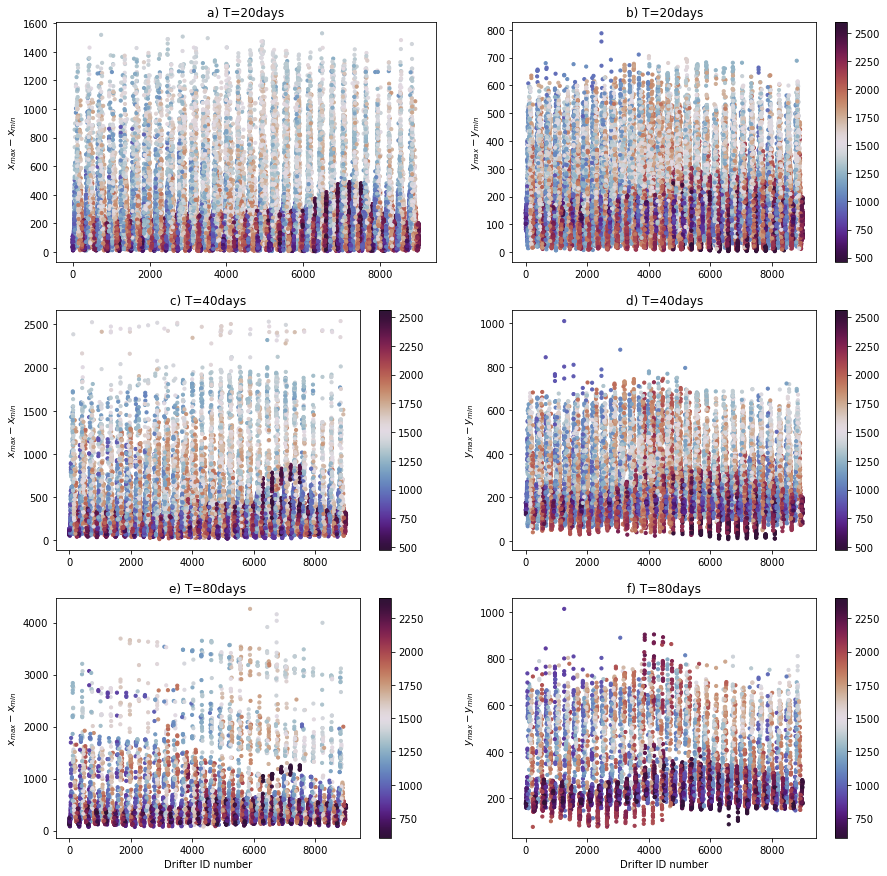

In [58]:
import matplotlib as mpl
cmap = mpl.cm.twilight_shifted
plt.set_cmap(cmap)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(3,2,1)
ds20.plot.scatter(x='id',y='xdiff',s=10,c=ds20.y0.values,cmap='viridis')
#plt.colorbar(cs)
ax.set_title('a) T=20days')
ax.set_xlabel('');ax.set_ylabel(r'$x_{max}-x_{min}$')
ax = fig.add_subplot(3,2,2)
cs = xr.plot.scatter(ds20,'id','ydiff',s=10,c=ds20.y0,ax=ax)
plt.colorbar(cs)
ax.set_title('b) T=20days')
ax.set_xlabel('');ax.set_ylabel(r'$y_{max}-y_{min}$')
ax = fig.add_subplot(3,2,3)
cs = xr.plot.scatter(ds40,'id','xdiff',s=10,c=ds40.y0,ax=ax)
plt.colorbar(cs)
ax.set_title('c) T=40days')
ax.set_xlabel('');ax.set_ylabel(r'$x_{max}-x_{min}$')
ax = fig.add_subplot(3,2,4)
cs = xr.plot.scatter(ds40,'id','ydiff',s=10,c=ds40.y0,ax=ax)
plt.colorbar(cs)
ax.set_title('d) T=40days')
ax.set_xlabel('');ax.set_ylabel(r'$y_{max}-y_{min}$')
ax = fig.add_subplot(3,2,5)
cs = xr.plot.scatter(ds80,'id','xdiff',s=10,c=ds80.y0,ax=ax)
plt.colorbar(cs)
ax.set_title('e) T=80days')
ax.set_xlabel('Drifter ID number');ax.set_ylabel(r'$x_{max}-x_{min}$')
ax = fig.add_subplot(3,2,6)
cs = xr.plot.scatter(ds80,'id','ydiff',s=10,c=ds80.y0,ax=ax)
plt.colorbar(cs)
ax.set_title('f) T=80days')
ax.set_xlabel('Drifter ID number');ax.set_ylabel(r'$y_{max}-y_{min}$')

#### Comments : 

General comments a,c,e: The drifters cover more distance in the x-direction with maxima increasing with the time periods (reaching 4000km for T=80days). Those maxima correspond to initial y near and in the jet while lower values (<300km) are found for low and high y0 .
General comments b,d,f: For all the time periods, the distance between covered extrema (in y) are found btw 0 and 200km for small (<1000km) and high (>2200km) values of initial y (y0). For other values of y0 this distance range btw 200km and $\sim$1000km in the y-direction.\


#### Averaging over initial bins

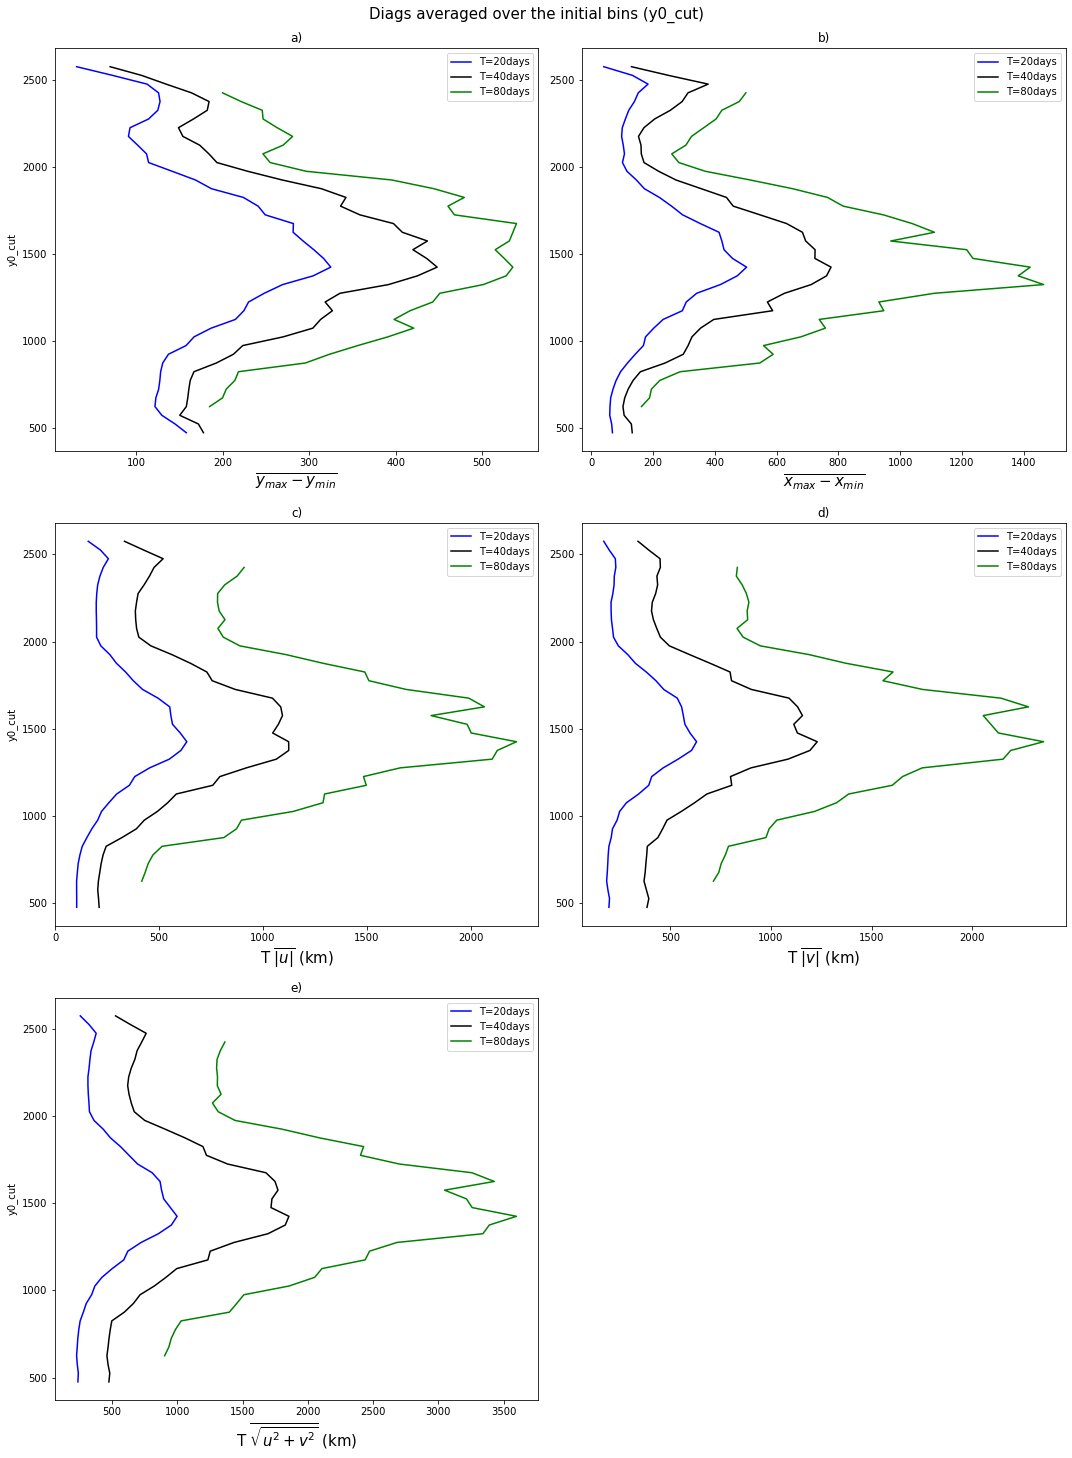

In [56]:
fontsize = 15
fig = plt.figure(figsize=(15,20))
fig.suptitle('Diags averaged over the initial bins (y0_cut)',x=0.5,y=1.01,fontsize=fontsize)
ax = fig.add_subplot(3,2,1)
ds20_stats.ydiff.plot(y='y0_cut',ax=ax,c='b',label='T=20days')
ds40_stats.ydiff.plot(y='y0_cut',ax=ax,c='k',label='T=40days')
ds80_stats.ydiff.plot(y='y0_cut',ax=ax,c='g',label='T=80days')
ax.set_xlabel(r'$\overline{y_{max}-y_{min}}$',fontsize=fontsize)
ax.set_title('a)')
plt.legend()
ax = fig.add_subplot(3,2,2)
ds20_stats.xdiff.plot(y='y0_cut',ax=ax,c='b',label='T=20days')
ds40_stats.xdiff.plot(y='y0_cut',ax=ax,c='k',label='T=40days')
ds80_stats.xdiff.plot(y='y0_cut',ax=ax,c='g',label='T=80days')
ax.set_xlabel(r'$\overline{x_{max}-x_{min}}$',fontsize=fontsize);ax.set_ylabel('')
ax.set_title('b)')
plt.legend()
ax = fig.add_subplot(3,2,3)
(20*24*3600*ds20_stats.dx*1e-3).plot(y='y0_cut',ax=ax,c='b',label='T=20days')
(40*24*3600*ds40_stats.dx*1e-3).plot(y='y0_cut',ax=ax,c='k',label='T=40days')
(80*24*3600*ds80_stats.dx*1e-3).plot(y='y0_cut',ax=ax,c='g',label='T=80days')
ax.set_xlabel(r'T $\overline{|u|}$ (km)',fontsize=fontsize)
ax.set_title('c)')
plt.legend()
ax = fig.add_subplot(3,2,4)
(20*24*3600*ds20_stats.dy*1e-3).plot(y='y0_cut',ax=ax,c='b',label='T=20days')
(40*24*3600*ds40_stats.dy*1e-3).plot(y='y0_cut',ax=ax,c='k',label='T=40days')
(80*24*3600*ds80_stats.dy*1e-3).plot(y='y0_cut',ax=ax,c='g',label='T=80days')
ax.set_xlabel(r'T $\overline{|v|}$ (km)',fontsize=fontsize);ax.set_ylabel('')
ax.set_title('d)')
plt.legend()
ax = fig.add_subplot(3,2,5)
(20*24*3600*ds20_stats.ds*1e-3).plot(y='y0_cut',ax=ax,c='b',label='T=20days')
(40*24*3600*ds40_stats.ds*1e-3).plot(y='y0_cut',ax=ax,c='k',label='T=40days')
(80*24*3600*ds80_stats.ds*1e-3).plot(y='y0_cut',ax=ax,c='g',label='T=80days')
ax.set_xlabel(r'T $\overline{\sqrt{u^2+v^2}}$ (km)',fontsize=fontsize)
ax.set_title('e)')
plt.tight_layout()
plt.legend()

### Comments:
a) The largest difference (>450km) between maximal and minimal y are found in initial bins in the jet ; smaller differencies being found far south (<1000km) and north (>2000km) from the jet, for all time periods. However the maxima increase with time period (from 300km for T=20 to >500km for T=80days).\
b) As in a) the largest values are found in the jet and increase with T (from 400km to 1400km). The maxima are superior to the ones in y which is coherent with what was said in the previous comment cell.\
c,d and e) As expected, large motions in and near the jet compared to the northern and southern parts.

#### Quantifying the number of drifters by areas

In [50]:
# Definition of regions : 
y1 = 1150
y2 = 1950
def drifters_regions(ds, y1,y2):
    id1 = ds.where(ds.y0<=y1,drop=True).id.values
    id3 = ds.where(ds.y0>y2,drop=True).id.values
    id2 = ds.id[np.isin(ds.id,id1)==False]
    id2 = id2[np.isin(id2,id3)==False]
    id11 = ds.where(ds.y1<=y1,drop=True).id.values
    id13 = ds.where(ds.y1>y2,drop=True).id.values
    id12 = ds.id[np.isin(ds.id,id11)==False]
    id12 = id12[np.isin(id12,id13)==False]
    print('Region 1 : South of the jet')
    print('Number of drifters in region 1 at t0: ',id1.size)
    print('Number of drifters in region 1 at t1 : ',id11.size)
    print('Number of drifters that left region 1 : ',id1[np.isin(id1,id11)==False].size)
    print('Region 2 : In and near the jet')
    print('Number of drifters in region 2 at t0 : ',id2.size)
    print('Number of drifters in regin 2 at t1 : ',id12.size)
    print('Number of drifters that left region 2 : ',id2[np.isin(id2,id12)==False].size)
    print('Number of drifters that left region 2 for region 1 : ',id2[np.isin(id2,id11)==True].size)
    print('Number of drifters that left region 2 for region 3 : ',id2[np.isin(id2,id13)==True].size)
    print('Region 3 : North the jet')
    print('Number of drifters in region 3 at t0 : ',id3.size)
    print('Number of drifters region 3 at t1 : ',id13.size)
    print('Number of drifters that left region 3 : ',id3[np.isin(id3,id13)==False].size)
    return [id1,id2,id3],[id11,id12,id13]
print('T=20 days (8 segments)')
id0_20,id1_20 = drifters_regions(ds20, y1,y2) 
print('-------------------')
print('T=40 days (3 segments)')
id0_40,id1_40 = drifters_regions(ds40, y1,y2) 
print('-------------------')
print('T=80 days (1 segment)')
id0_80,id1_80 = drifters_regions(ds80, y1,y2) 

T=20 days (8 segments)
Region 1 : South of the jet
Number of drifters in region 1 at t0:  21880
Number of drifters in region 1 at t1 :  21849
Number of drifters that left region 1 :  199
Region 2 : In and near the jet
Number of drifters in region 2 at t0 :  16836
Number of drifters in regin 2 at t1 :  16266
Number of drifters that left region 2 :  2695
Number of drifters that left region 2 for region 1 :  1182
Number of drifters that left region 2 for region 3 :  1513
Region 3 : North the jet
Number of drifters in region 3 at t0 :  17895
Number of drifters region 3 at t1 :  17884
Number of drifters that left region 3 :  125
-------------------
T=40 days (3 segments)
Region 1 : South of the jet
Number of drifters in region 1 at t0:  8207
Number of drifters in region 1 at t1 :  8173
Number of drifters that left region 1 :  454
Region 2 : In and near the jet
Number of drifters in region 2 at t0 :  8589
Number of drifters in regin 2 at t1 :  8511
Number of drifters that left region 2 :  19

#### Comments :
In this part we seek to quantify a tendency depending on the initial area. For this we define 3 regions : south, in and near the jet and north).\
For each time window size (20, 40, 80 days), the total number of drifters by area does not change much.\
Only a small part of the drifters leave their initial regions far from the jet compared to the areas closer to the jet.\
Most of the change is observe in region 2 with approximatly 1/5 of the drifters leaving the area. The turbulent jet seems to be an area where the drifters don't remain for long time periods. We can also note the northward tendency. We still note that in this region to the number of drifters between t0 and t1 does not change a lot (at most a few hundreds for T=20days).\

In [17]:
cluster.close()